<a href="https://colab.research.google.com/github/supritk21/object_localization/blob/main/Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

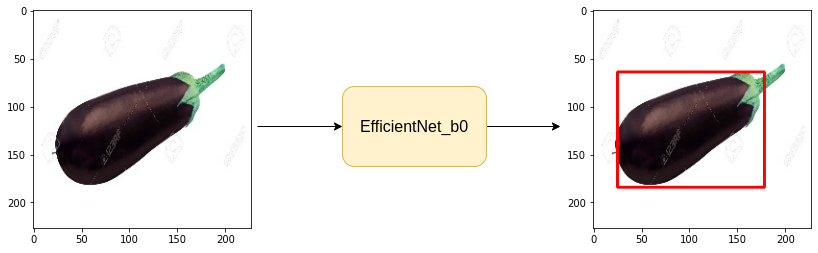

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-5qz1oxip
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-5qz1oxip
  Resolved https://github.com/albumentations-team/albumentations to commit c0af8032c4efa8f3c15c4493d6e13c110d47aba7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for albumentations: filename=albumentations-1.4.15-py3-none-any.whl size=200301 sha256=f6e7c0d8380415875a06ba7302500823fb988033ca275a1c5b17f165077fc55e
  Stored in directory: /tmp/pip-ephem-wheel-cache-4vgw8_6x/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.14
    Uninstalling albucore-0.0.14:
      Successfully uninstalled albucore-0.0.14
  Attempting uninstall: al

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 29.79 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
csv_file = "/content/object-localization-dataset/train.csv"
data_dir = "/content/object-localization-dataset/"

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

lr = 0.001
epochs = 40

MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4


In [ ]:
df = pd.read_csv(csv_file)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

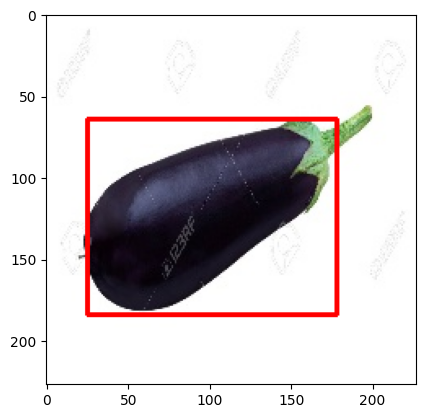

In [ ]:
row = df.iloc[100]
img = cv2.imread(data_dir  + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (int(row.xmin), int(row.ymin))
pt2 = (int(row.xmax), int(row.ymax))

bnd_img = cv2.rectangle(img,pt1, pt2,(255,0,0),2)

plt.imshow(bnd_img)
# print(img)



In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42 )

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjectLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, augumentations = None):
    self.df = df
    self.augumentations = augumentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
      row = self.df.iloc[idx]

      xmin = row.xmin
      xmax = row.xmax
      ymin = row.ymin
      ymax = row.ymax

      bbox = [[xmin, ymin, xmax, ymax]]
      img_path = data_dir + row.img_path

      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      if self.augumentations:
        aug_result = self.augumentations(image = img, bboxes = bbox, class_labels = [None])
        img = aug_result['image']
        bbox = aug_result['bboxes'][0]

      img = torch.from_numpy(img).permute(2,0,1)/255.0 # h , w, c -> c, h, w
      bbox = torch.tensor(bbox)

      return img, bbox


In [ ]:
trainset = ObjectLocDataset(train_df, augumentations = train_augs)
validset = ObjectLocDataset(valid_df, augumentations = train_augs)

In [ ]:
print("local example in train set  ", len(trainset))

local example in train set   148


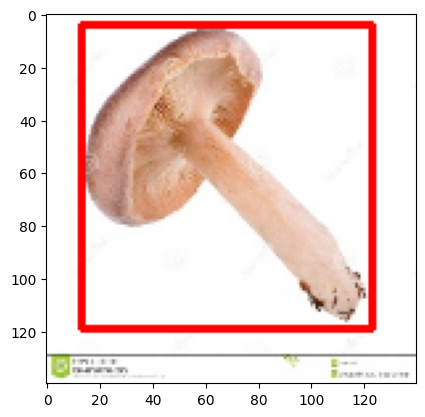

In [ ]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE,shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE,shuffle = False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):
   def __init__(self):
      super(ObjLocModel, self).__init__()

      self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

   def forward(self, images, gt_bboxes = None):

      bboxes = self.backbone(images)

      if gt_bboxes != None :
         loss = nn.MSELoss()(bboxes, gt_bboxes)
         return bboxes, loss

      return bboxes



In [ ]:
model = ObjLocModel()
model.to(DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

In [ ]:
rand_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(rand_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, trainloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(trainloader):
    images, gt_bboxes = data

    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    optimizer.zero_grad()

    bboxes, loss = model(images, gt_bboxes)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(trainloader)

In [ ]:
def eval_fn(model, valloader):
  total_loss = 0.0
  model.eval()

  for data in tqdm(valloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    total_loss += loss.item()

  return total_loss/len(valloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
best_valid_loss = np.Inf

for epoch in range(epochs):
  train_loss = train_fn(model, trainloader, optimizer)
  val_loss = eval_fn(model, validloader)

  if val_loss< best_valid_loss:
    best_valid_loss = val_loss
    torch.save(model.state_dict(), "best_model.pt")
    print("Saved Best Model")

  print("Epoch : {}, Train Loss : {}, Val Loss : {}".format(epoch, train_loss, val_loss))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 0, Train Loss : 4904.180151367187, Val Loss : 3053.4969889322915


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 1, Train Loss : 1736.7154541015625, Val Loss : 1638.6471761067708


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 2, Train Loss : 968.7612091064453, Val Loss : 273.9264678955078


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 3, Train Loss : 621.6287384033203, Val Loss : 161.76231384277344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4, Train Loss : 446.5595001220703, Val Loss : 173.28334045410156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 5, Train Loss : 268.9374145507812, Val Loss : 110.89556376139323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 6, Train Loss : 184.99808731079102, Val Loss : 98.28683217366536


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7, Train Loss : 118.4995018005371, Val Loss : 124.60599009195964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 8, Train Loss : 93.44336471557617, Val Loss : 81.68471908569336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9, Train Loss : 75.71839256286621, Val Loss : 91.70747884114583


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 10, Train Loss : 59.54571113586426, Val Loss : 67.54248746236165


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 11, Train Loss : 40.211972618103026, Val Loss : 53.797752380371094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12, Train Loss : 43.750576210021975, Val Loss : 70.7119649251302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 13, Train Loss : 31.293563652038575, Val Loss : 49.48772048950195


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14, Train Loss : 32.224240112304685, Val Loss : 49.56745402018229


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 15, Train Loss : 26.699642276763917, Val Loss : 49.25510279337565


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16, Train Loss : 34.0328447341919, Val Loss : 49.30414326985677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17, Train Loss : 31.255915451049805, Val Loss : 49.54601287841797


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 18, Train Loss : 21.139613723754884, Val Loss : 44.35774485270182


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19, Train Loss : 22.565521335601808, Val Loss : 45.77676518758138


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 20, Train Loss : 28.108342933654786, Val Loss : 42.454210917154946


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 21, Train Loss : 23.28070306777954, Val Loss : 41.28312110900879


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 22, Train Loss : 18.42276096343994, Val Loss : 39.36256726582845


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23, Train Loss : 23.27678985595703, Val Loss : 44.99398422241211


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24, Train Loss : 48.420354747772215, Val Loss : 41.59161949157715


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25, Train Loss : 19.10420846939087, Val Loss : 43.51989873250326


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26, Train Loss : 22.247620105743408, Val Loss : 47.70911534627279


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27, Train Loss : 26.398186683654785, Val Loss : 44.12840143839518


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28, Train Loss : 21.834974908828734, Val Loss : 40.80439885457357


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29, Train Loss : 20.02333517074585, Val Loss : 49.51220575968424


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 30, Train Loss : 24.651324367523195, Val Loss : 37.019033432006836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31, Train Loss : 22.280134677886963, Val Loss : 51.02142779032389


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32, Train Loss : 21.78367199897766, Val Loss : 42.877102533976235


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33, Train Loss : 14.715471696853637, Val Loss : 39.89594268798828


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34, Train Loss : 15.63310947418213, Val Loss : 37.164194107055664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 35, Train Loss : 16.938633918762207, Val Loss : 34.27824020385742


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36, Train Loss : 20.49466953277588, Val Loss : 39.982154846191406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37, Train Loss : 17.261310195922853, Val Loss : 40.00041198730469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38, Train Loss : 13.718991780281067, Val Loss : 39.14923222859701


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39, Train Loss : 22.563961219787597, Val Loss : 40.74942398071289


#Inference

In [ ]:
import cv2
import numpy
import torch

import matplotlib.pyplot as plt

def compare_plots(image, gt_bbox, out_bbox):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)

In [ ]:
# import sys
# sys.path.append('content/object-localization-dataset')
# import utils

<ipython-input-88-69da77f66720>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


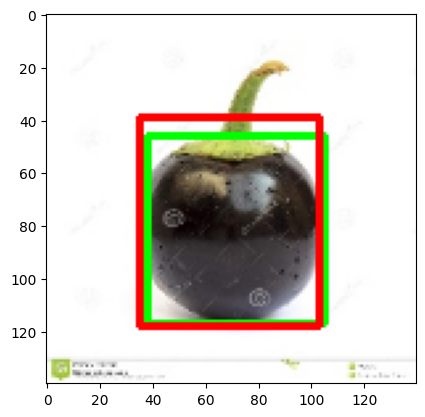

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

with torch.no_grad():

   image, gt_bbox = validset[20]
   image = image.unsqueeze(0).to(DEVICE)

   out_bbox = model(image)

   compare_plots(image, gt_bbox, out_bbox)


# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya